In [6]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Baseline GNN Metrics 

For the model created in the last script, get predictions and metrics / performance information.  Focus on the unseen "test" data.  Use sklearn metrics to ensure comparability with XGBoost metrics

Implementation notes:
  * To visualize the keras model, I had to "conda install" pydot and graphviz in my virtual environment. 
  * Model is saved/loaded in tensorflow format.  This is to workaround an issue with Keras format, https://github.com/tensorflow/tensorflow/issues/46659

*This script takes about 2 hours on my MacBook Air*

In [7]:
import pandas as pd
import numpy as np

In [101]:
from pathlib import Path
import importlib, pickle
from contextlib import redirect_stdout
from scikitplot.metrics import plot_lift_curve
import matplotlib.pyplot as plt

In [18]:
from stellargraph import StellarGraph
import stellargraph as sg
import keras
from stellargraph.layer import HinSAGE, MeanHinAggregator
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import tensorflow.keras.metrics as km
from keras.utils import plot_model
from keras import initializers
import tensorflow as tf

In [10]:
from sba_gnn.sba_gnn import sg_gnn, sg_plot 

## Import Data

##### Stellargraphs - all data, test only data

In [11]:
# Training and validation clients - monitor training on val clients
with open(Path(setup.temp_path).joinpath('11_DATA_stellargraph_all.pkl'), 'rb') as fin:
      sba_all  = pickle.load(fin)

In [12]:
labels_all = pd.read_parquet(Path(setup.temp_path).joinpath('11_DATA_label_info.parquet'))

In [13]:
# Training and validation clients - monitor training on val clients
with open(Path(setup.temp_path).joinpath('11_DATA_stellargraph_test.pkl'), 'rb') as fin:
      sba_test  = pickle.load(fin)

In [14]:
labels_test = pd.read_parquet(Path(setup.temp_path).joinpath('11_DATA_labels_test.parquet'))

##### Model

In [19]:
model = keras.models.load_model(Path(setup.temp_path).joinpath('12_DATA_model.keras'),
                               safe_mode=False,
                               custom_objects={'MeanHinAggregator':MeanHinAggregator})

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Model Info
Print and save some information about the model layers (summary and plot)

In [22]:
with open(Path(setup.temp_path).joinpath('13_REPORT_model_summary.txt'), "w") as f:
    with redirect_stdout(f):
        print(model.summary())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200, 10)]            0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 200, 10)]            0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 200, 10)]            0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 200, 10)]            0         []                            
                                                                                              

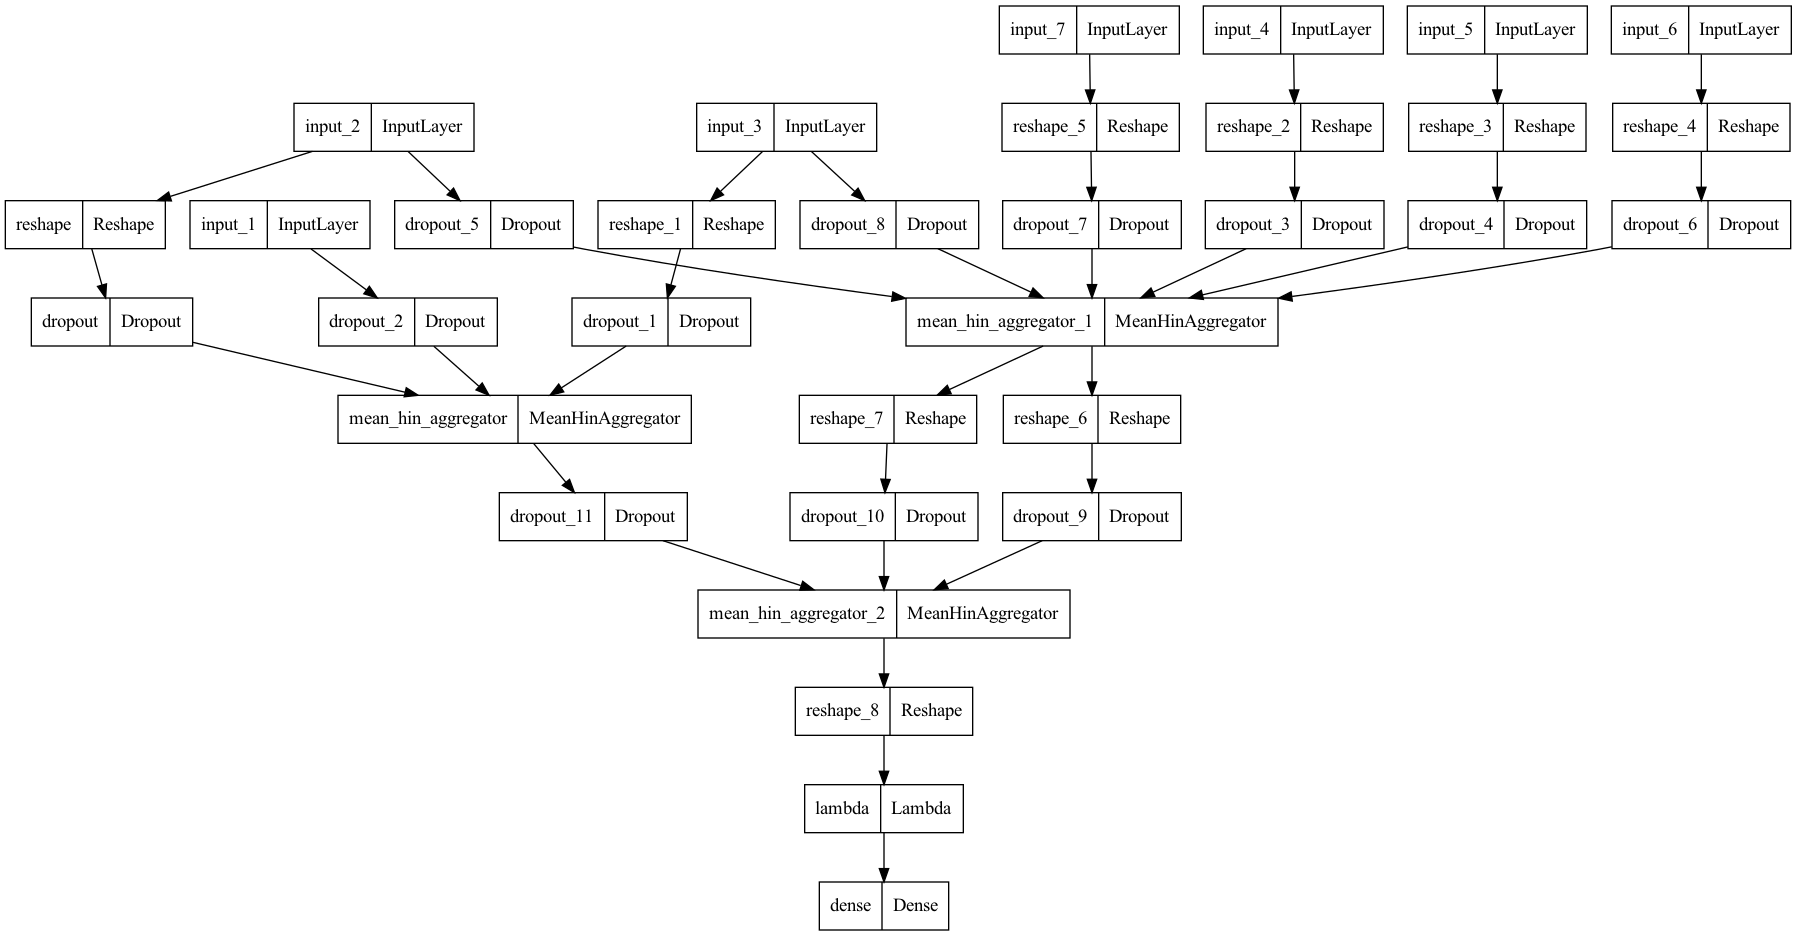

In [23]:
plot_model(model, Path(setup.temp_path).joinpath('13_model_plot_simp.png'))

The 2-hop model has three MeanHinAggregator layers, likely reflecting the 2 edge types.

In [24]:
%%capture
plot_model(model, to_file=Path(setup.temp_path).joinpath('13_model_plot_with_shapes.png'),
          show_shapes=True)

## Graph Containing All Nodes
Get predictions amd metrics

##### Get generator and predict for all nodes (train, validation, test)

In [25]:
generator = HinSAGENodeGenerator(sba_all, batch_size=100, 
                                 num_samples=[10, 20], 
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=34)

In [26]:
all_flow = generator.flow(labels_all.index, labels_all['target'], shuffle=False)

In [27]:
tf.random.set_seed(16)
keras.utils.set_random_seed(812)
sg.random.set_seed(4345)

In [28]:
all_predictions = model.predict(all_flow)

2023-12-17 21:49:55.669030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17203/17203 [==============================] - 1454s 84ms/step


In [32]:
all_predictions.shape

(688081, 1)

In [35]:
all_predictions[:,0].shape

(688081,)

In [40]:
pd.Series(all_predictions[:,0], index=labels_all.index)

LoanNr_ChkDgt
5282874009    0.153905
2568556001    0.151879
2687465005    0.164046
9174473001    0.119753
3598634004    0.189337
                ...   
1533475000    0.289995
2597975001    0.330402
4381063007    0.209738
6010603003    0.122478
3215386008    0.321304
Length: 688081, dtype: float32

In [82]:
all_pred_df = pd.Series(all_predictions[:,0], index=labels_all.index).rename('predict_prob').reset_index()

In [84]:
all_pred_df.head(3)

,LoanNr_ChkDgt,predict_prob
0,5282874009,0.153905
1,2568556001,0.151879
2,2687465005,0.164046


## Threshold Tune & Binary Predictions
Using training probability predictions

In [72]:
thresh_tune_data = sg_plot.get_f1_frame(labels_all[labels_all['dset'] == 'train']['target'], 
                                        all_pred_df[all_pred_df['dset'] == 'train']['predict_prob'])

In [73]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
12,0.24,0.406070
13,0.26,0.406056
11,0.22,0.405543


In [74]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.24

##### Append binary predictions to probability predictions

In [75]:
importlib.reload(sg_plot)

<module 'sba_gnn.sba_gnn.sg_plot' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_plot.py'>

In [85]:
all_pred_df['predict_bin'] = sg_plot.get_binary_predictions(all_pred_df['predict_prob'], best_thresh)

In [86]:
all_pred_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.582953
0    0.417047
Name: proportion, dtype: float64

In [87]:
all_pred_df = all_pred_df.merge(labels_all.reset_index(), on='LoanNr_ChkDgt')

In [88]:
all_pred_df.to_parquet(Path(setup.temp_path).joinpath('13_DATA_predictions_all.parquet'))

In [89]:
all_pred_df.sample(3)

,LoanNr_ChkDgt,predict_prob,predict_bin,dset,target,train_fix
353725,2439185005,0.378028,1,train,0,1.0
88047,8832934002,0.351341,1,train,1,0.0
451206,2581644006,0.234898,0,test,0,0.0


In [90]:
pd.crosstab(all_pred_df['predict_bin'], all_pred_df['target'])

target,0,1
predict_bin,,
0,256243,30719
1,292150,108969


## Metrics

In [91]:
metrics_df = pd.concat([sg_plot.dset_metrics(all_pred_df[all_pred_df['dset'] == d]['target'], 
                                             all_pred_df[all_pred_df['dset'] == d]['predict_bin'], 
                                             all_pred_df[all_pred_df['dset'] == d]['predict_prob']) \
                        for d in ['train', 'val', 'test']], axis=1,
                      keys = ['train', 'val', 'test']) \
    .transpose()
metrics_df.to_csv(Path(setup.temp_path).joinpath('13_REPORT_metrics_all.csv'), index=True)
metrics_df

,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
train,0.540058,0.406070,0.275171,0.774497,0.308244,0.672556
val,0.512924,0.397839,0.265570,0.792596,0.307865,0.663757
test,0.513914,0.397264,0.265456,0.789057,0.303279,0.661836


## Lift

In [92]:
pred_test_df = all_pred_df[all_pred_df['dset'] == 'test']

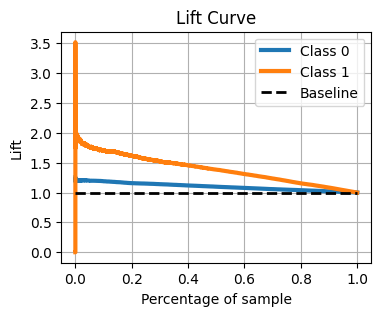

In [102]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('13_PLOT_lift_curve.png'),bbox_inches='tight')

## Embeddings
Extract node embeddings for businesses, and save these for later analysis

In [135]:
# Create a new model object to access the embeddings 1 layers above (normalized output)
emb_model = Model(inputs=model.input, outputs=model.layers[-1].output)

In [ ]:
embeddings = emb_model.predict(all_flow)

2023-12-20 07:51:38.181055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1660/17203 [=>............................] - ETA: 10:44

In [ ]:
embeddings_df = pd.DataFrame(embeddings, index=labels_all.index)
embeddings_df.columns = [f'emb_{c:02d}' for c in embeddings_df.columns]

In [ ]:
embeddings_df.describe()

In [133]:
embeddings_df.describe()

,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,-0.233674,-0.182344,-0.341841,0.141774,0.087658,-0.310706,0.221978,0.660092
std,0.127160,0.164813,0.158454,0.042852,0.176450,0.183110,0.172307,0.146099
min,-0.507903,-0.866867,-0.726170,-0.171166,-0.244393,-0.752536,-0.416352,-0.119232
25%,-0.323981,-0.161752,-0.437999,0.125731,-0.055718,-0.472807,0.122621,0.554479
50%,-0.276056,-0.122917,-0.335646,0.144267,0.049710,-0.317320,0.231313,0.701063
75%,-0.174930,-0.099376,-0.246826,0.165613,0.214021,-0.142273,0.343616,0.774657
max,0.398164,-0.009859,0.395445,0.284151,0.769049,0.056690,0.600746,0.903851


In [134]:
embeddings_df.to_parquet(Path(setup.temp_path).joinpath('13_DATA_embeddings.parquet'))

## Metrics on Test-Only Graph
Repeat metrics on the test nodes (and associated NAICS nodes) only.  Expect some performance degradation

In [ ]:
TO DO
- Check prediction outputs.  Consider sampling or see how batch size can change runtime (GPU nowhere near maxed at 40)
- Finish!  All metrics, lift then test only
- Embeddings for training data
- Run magic!
- Replace xgboost script code 
- GNN models (repeat processes)
  - "label trick"
  - mean encoding
  - both
- XGBoost plus embeddings